# **Laminar Viscous-Inviscid Interaction Solver using Thwaites Method**

---

AE 5012 Viscous Flow Major Assignment \\

Group 2: 

*   23621008 - David Waldo Parlindungan 
*   23621020 - Al-Faisal Firdaus
*   13618036 - Muhamad Abdul Aziz

 
References: \\
[1] Moran, J. (2013). An introduction to theoretical and Computational Aerodynamics. Dover Publications. \\
[2] Degrez, G. (2012). Two-dimensional Boundary Layers. \\
[3] Kuethe, A. M., &amp; Chow, C.-Y. (2000). Foundations of aerodynamics: Bases of aerodynamic design. J. Wiley \\

---


# Import Libraries

In [ ]:
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Airfoil Builder

In [ ]:
def Airfoil_builder(X, Y, n_p):
  #This is used to reshape the airfoil into a closed TE airfoil.
  #This function can also recreate total number of points in the airfoil

  dist = 0

  for i in range(len(X)):
    temp = (X[i]-X[0])**2 - (Y[i]-Y[0])**2
    dist = max(dist,temp)
    if (dist != temp):
      nLE = i - 1
      break

  # Transform x coordinate to psi
  
  ch = np.abs(X[nLE] - X[0])
  psi = np.zeros(len(X))
  for i in range(len(X)):
    phiA   = m.acos((X[i]-0.5*ch)/(0.5*ch)) 
    if (i <= nLE):
      psi[i] = phiA
    elif (i >= nLE):
      psi[i] = 2*np.pi - phiA
  
  # Cubic spline yA as function of psi
  cs = CubicSpline(psi,Y)
  
  # Define new psi
  psiA = np.linspace(0,2*np.pi,n_p)

  # Compute new airfoil coordinate
  rBx      = np.zeros([n_p])
  rBy      = np.zeros([n_p])
  rBx = 0.5*ch*(1+np.cos(psiA))
  rBy = cs(psiA)

  return rBx, rBy


# Vortex Panel Method

In [ ]:
def vortexpanelmethod(aoa, Gee, Xb, Yb):

    M = len(Xb)-1           # Number of points
    MP1 = M+1               # M plus 1
    alpha = aoa * m.pi/180  # in radian

    X = np.zeros(M)
    Y = np.zeros(M)
    S = np.zeros(M)
    Theta = np.zeros(M)
    Sine = np.zeros(M)
    Cosine = np.zeros(M)
    RHS = np.zeros(M+1)
    RHSC = np.zeros(M)

    for i in range(0,M): 
        ip1 = i + 1
        X[i] = 0.5 * (Xb[i] + Xb[ip1])
        Y[i] = 0.5 * (Yb[i] + Yb[ip1])
        S[i] = np.sqrt((Xb[ip1]-Xb[i])**2 + (Yb[ip1]-Yb[i])**2 )
        Theta[i] = m.atan2(Yb[ip1]-Yb[i], Xb[ip1]-Xb[i])
        Sine[i] = m.sin (Theta[i])
        Cosine[i] = m.cos (Theta[i])
        RHS[i] = m.sin(Theta[i] - alpha)+ Gee[i]
        RHSC[i] = m.cos(Theta[i] - alpha)
    
    CN1 = np.zeros([M,M])
    CN2 = np.zeros([M,M])
    CT1 = np.zeros([M,M])
    CT2 = np.zeros([M,M])

    for i in range(0,M):
        for j in range(0,M):
            if (i==j):
                CN1[i,j] = -1
                CN2[i,j] = 1
                CT1[i,j] = 0.5*np.pi
                CT2[i,j] = 0.5*np.pi
            else:
                A = -(X[i]-Xb[j])*Cosine[j] - (Y[i]-Yb[j])*Sine[j]
                B = (X[i]-Xb[j])**2 + (Y[i]-Yb[j])**2
                C = np.sin(Theta[i]-Theta[j])
                D = np.cos(Theta[i]-Theta[j])
                E = (X[i]-Xb[j])*Sine[j] - (Y[i] - Yb[j])*Cosine[j]
                F = m.log(1 + S[j]*(S[j]+2*A)/B)
                G = m.atan2(E*S[j], B+A*S[j])
                P = (X[i]-Xb[j])*np.sin(Theta[i]-2*Theta[j])+(Y[i]-Yb[j])*np.cos(Theta[i]-2*Theta[j])
                Q = (X[i]-Xb[j])*np.cos(Theta[i]-2*Theta[j])-(Y[i]-Yb[j])*np.sin(Theta[i]-2*Theta[j])
                CN2[i,j] = D + 0.5*Q*F/S[j] - (A*C+D*E)*G/S[j]
                CN1[i,j] = 0.5*D*F + C*G - CN2[i,j]
                CT2[i,j] = C + 0.5*P*F/S[j] +(A*D-C*E)*G/S[j]
                CT1[i,j] = 0.5*C*F - D*G -CT2[i,j]
    
    AN = np.zeros([M+1,M+1])
    AT = np.zeros([M,M+1])
    for i in range(0,M):
        AN[i,0] = CN1[i,0]
        AN[i,MP1-1] = CN2[i,M-1]
        AT[i,0] = CT1[i,0]
        AT[i,MP1-1]=CT2[i,M-1]
        for j in range(1, M):
            AN[i,j] = CN1[i,j]+CN2[i,j-1]
            AT[i,j] = CT1[i,j]+CT2[i,j-1]

        AN[M,0] = 1
        AN[M,M] = 1
        for j in range(1, M):
            AN[MP1-1,j] = 0

        RHS[MP1-1] = Gee[MP1-1]


    Gam = np.dot(np.linalg.inv(AN),RHS)
    Vtan = np.transpose(RHSC) + np.dot(AT,Gam)
    Vplot = Vtan/np.max(Vtan)
    Cp = 1-Vtan**2
    Vtanabs = abs(Vtan)

    return Vtanabs, X, Y, Cp

# Thwaites Method

In [ ]:
def thwaites_method(U, Vtan, X, Y, nu):
    Uin = Vtan * U
    Uin.reshape(len(X),1)
    M = len(X) 
    MP1 = M+1 

    # Variable initialization
    theta = np.zeros(M)       # Momentum thickness
    stag_l = np.argmin(Uin)+1 # Stagnation point (upper)
    stag_u = stag_l           # Stagnation point (lower)
    L = np.zeros(M)           # Shear Correlation
    H = np.zeros(M)           # Shape Factor
    cf1 = np.zeros(M)         # Friction Coefficient (Upper)
    cf2 = np.zeros(M)         # Friction Coefficient (Lower)
    tauw = np.zeros(M)        # Shear stress
    delta = np.zeros(M)       # Displacement thickness
    YBL = np.zeros(M)         # Boundary Layer


    theta[stag_u] = np.sqrt(0.075*nu/(abs((Uin[(stag_u)+1]-Uin[stag_u]/(X[(stag_u)+1]-X[(stag_u)])))))
    for j in range(stag_u+1, M):
        int1 = 0
        for i in range(stag_u+1, j):
            int1 = int1 + (Uin[i]**5 + Uin[i-1]**5)*abs((X[i]-X[i-1]))/2
        theta[j] = np.sqrt(0.45*nu*int1/(Uin[j]**6))
    
    theta[stag_l] = np.sqrt(0.075*nu/(abs((Uin[(stag_l)-1]-Uin[stag_l]/(X[(stag_l)-1]-X[(stag_l)])))))
    for j in range(stag_l-1, -1, -1):
        int1 = 0
        for i in range(stag_l-1, j, -1):
            int1 = int1 + (Uin[i]**5 + Uin[i+1]**5)*abs((X[i]-X[i+1]))/2
        theta[j] = np.sqrt(0.45*nu*int1/(Uin[j]**6))

    lamda = np.zeros(M)
    lamda[stag_u] = ((theta[stag_u]**2)/nu)*(Uin[stag_u+1]-Uin[stag_u])/abs((X[stag_u+1]-X[stag_u]))
    for i in range(stag_u+1, M):
        lamda[i] = ((theta[i]**2)/nu)*(Uin[i]-Uin[i-1])/abs((X[i]-X[i-1]))
    
    lamda[stag_l] = ((theta[stag_l]**2)/nu)*(Uin[stag_l-1]-Uin[stag_l])/abs((X[stag_l-1]-X[stag_l]))
    for i in range(stag_l-1, -1, -1):
        lamda[i] = ((theta[i]**2)/nu)*(Uin[i]-Uin[i+1])/abs((X[i]-X[i+1]))
  
    # L and H are calculated using Cebecci and Bradshaw formula 
    for i in range(stag_u, M):
        if lamda[i]<0.1 and lamda[i] > 0:
            L[i] = 0.22 + 1.57*lamda[i] -1.8*lamda[i]**2
            H[i] = 2.61 - 3.75*lamda[i] + 5.24*lamda[i]**2
        elif lamda[i]<=0 and lamda[i]>-0.1 :
            L[i] = 0.22 + 1.402*lamda[i] + 0.018*lamda[i]/(lamda[i]+0.107)
            H[i] = 2.088 + 0.0731/(lamda[i]+0.14)
        else:
            L[i] = L[i-1]
            H[i] = H[i-1]

        if theta[i]==0:
            cf1[i] = 0
        else:
            cf1[i] = 2*L[i]*nu/(Uin[i]*theta[i])
   
        tauw[i] = L[i]*miu*Uin[i]/theta[i]
        delta[i] = theta[i]*H[i]
    
    for i in range(stag_l,-1,-1):
        if lamda[i]<0.1 and lamda[i]>0:
            L[i] = 0.22 + 1.57*lamda[i] -1.8*lamda[i]**2
            H[i] = 2.61 - 3.75*lamda[i] + 5.24*lamda[i]**2
        elif lamda[i]<=0 and lamda[i]>-0.1:
            L[i] = 0.22 + 1.402*lamda[i] + 0.018*lamda[i]/(lamda[i]+0.107)
            H[i] = 2.088 + 0.0731/(lamda[i]+0.14)
        else:
            L[i] = L[i+1]
            H[i] = H[i+1]

        if theta[i]==0:
            cf2[i] = 0
        else:
            cf2[i] = 2*L[i]*nu/(Uin[i]*theta[i])
        
        tauw[i] = L[i]*miu*Uin[i]/theta[i]
        delta[i] = theta[i]*H[i]

    # Search the separation point using 
    for i in range(stag_u, M):
        if lamda[i]<=-0.0842:
            xsepu = X[i]
            transp1 = i
            break
        else:
            xsepu = X[M-1]
            transp1 = M-1
        
    for i in range(stag_l, 0, -1):
        if lamda[i]<=-0.0842:
            xsepl = X[i]
            transp2 = i
            break
        else:
            xsepl = X[1]
            transp2 = 1
    
    for i in range(0, M):
       if Y[i]>0:
           YBL[i] = Y[i] + delta[i]
       else:
           YBL[i] = Y[i] - delta[i]
    
    Gee = 0.03 * delta

    return cf1, cf2, delta, Gee, YBL, transp1, transp2, theta, stag_u, stag_l

# Main Program

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in double_scalars


Lift Coefficient: 0.845316
Drag COefficient: 0.074842


Text(0, 0.5, 'Cf')

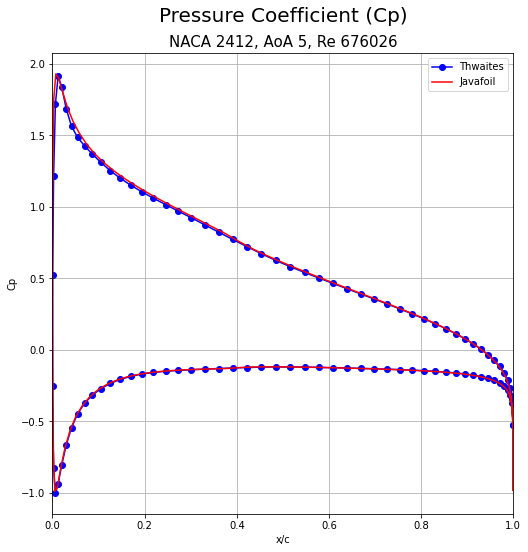

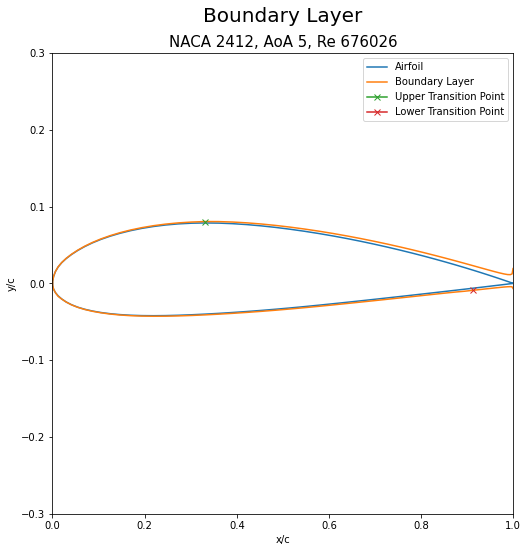

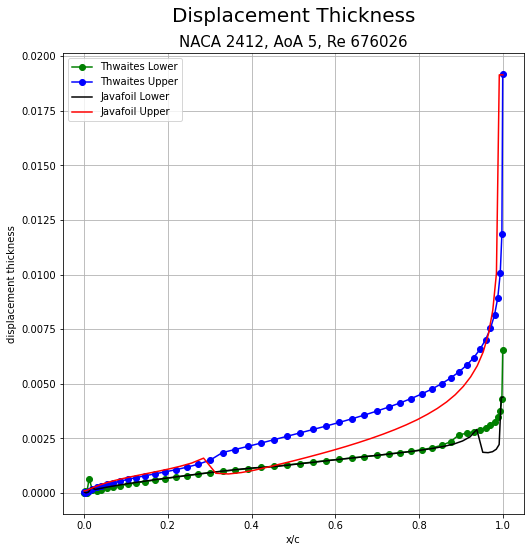

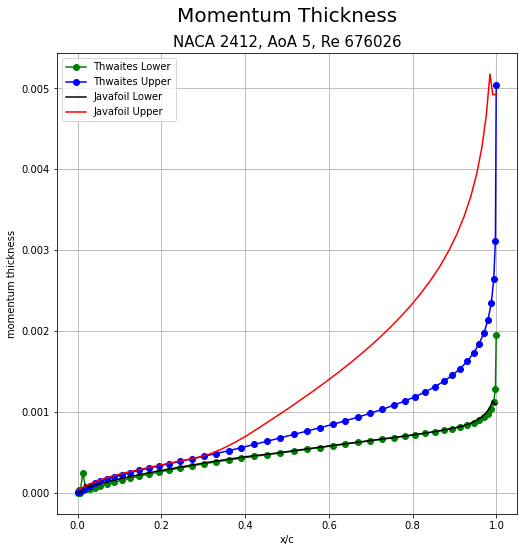

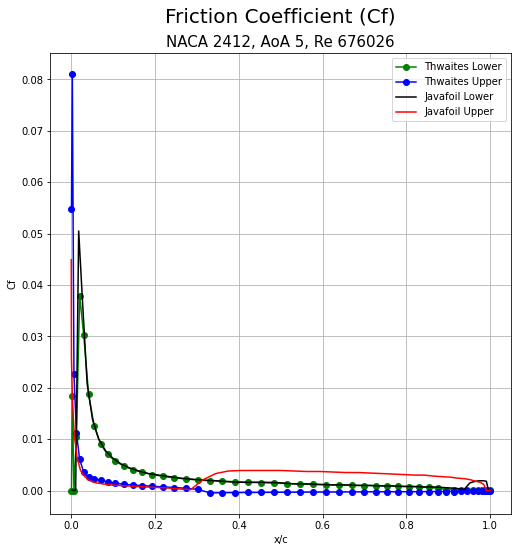

In [ ]:
# Before run the program, make sure you've upload all csv file in Airfoil and Javafoil result

# Select / input naca airfoil using string format (here is 0024 or 2412)
# airfoil = '0024'
airfoil = '2412'
df = pd.read_csv('NACA%s.csv' %airfoil)

# Choose case, make sure the data is available in folder Airfoil and Javafoil result
U = 10    # Velocity (V)
aoa = 5   # Angle of Attack (AoA)

miu = 0.0000181206    # Dynamic Viscosity at SL
rho = 1.225           # Density at SL
nu = miu/rho          # Kinematic Viscosity
Re = U/nu             # Reynolds number

# Select desired number of point to be used in airfoil builder
Num_points = 101 # Total number of points (must be odd)
# Note that in our example validation (javafoil), we use 101 points

# Reverse indexing, panel 1 begin from lower section trailing edge
dfinv = df.iloc[::-1]

# Extract x and y coordinate
Xb = dfinv.iloc[:,0]
Yb = dfinv.iloc[:,1]
Xb = np.array(Xb) 
Yb = np.array(Yb) 

# Start the airfoil builder
Xb, Yb = Airfoil_builder(Xb, Yb, Num_points )

# Initialization
M = len(Xb)-1
G = np.zeros(M+1)
delta = np.ones((M))
transp1 = 0
transp2 = 0
ii=1
errordelta = 100;
Cn_u = 0
Cn_l=0
Ca_u = 0
Ca_l=0

# Viscous-Inviscid Loop
while errordelta >= 1e-06:
    deltaimin1 = delta # thickness at previous iter
    [Vtan, X, Y, Cp] = vortexpanelmethod(aoa, G, Xb, Yb) # solve vortex panel
    [Cf1, Cf2, delta, Gee, YBL, transp1, transp2, teta, stag_u, stag_l] = thwaites_method(U, Vtan, X, Y, nu) # solve BL
    G = np.append(G, 0) 
    
    cek =0

    for i in range(0,len(X)):
      if(delta[i]) != 0:
        cek += abs(delta[i] - deltaimin1[i])/delta[i]
      else:
        cek += 0
    errordelta = cek
    
    if ii == 1:
        CP1 = Cp
    ii=ii+1
    if ii == 100:
      break
    
# Normal coefficient (Cn)
# upper
for i in range (stag_u, M-1):
    Cn_u = Cn_u + (Cp[i+1]+Cp[i])*(X[i+1]-X[i])/2
# lower
for i in range (stag_l,1,-1):
    Cn_l = Cn_l + (Cp[i-1]+Cp[i])*(X[i-1]-X[i])/2
Cn = (Cn_l - Cn_u)

# Axial coefficent (Ca)
# upper
for i in range (stag_u, transp1):
    Ca_u = Ca_u + (Cf1[i+1]+Cf1[i])*(X[i+1]-X[i])/2
# lower
for i in range (stag_l,transp2,-1):
    Ca_l = Ca_l + (Cf1[i-1]+Cf1[i])*(X[i-1]-X[i])/2
Ca = Ca_u + Ca_l 

# Lift and Drag Coefficients
Cl = Cn*m.cos(m.radians(aoa)) - Ca*m.sin(m.radians(aoa))
Cd = Cn*m.sin(m.radians(aoa)) +Ca*m.cos(m.radians(aoa))

print('Lift Coefficient: %f'%Cl)
print('Drag COefficient: %f'%Cd)

# Extract data from Javafoil
df_ref = pd.read_csv('NACA%s_AoA%i_V%i.csv'%(airfoil,aoa,U))
df_refInv = df_ref.iloc[::-1]

# Visualization
# Plot Cp
fig = plt.figure(figsize = (8,8))
CpPlot = -Cp
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(X, CpPlot, color = 'blue', label = 'Thwaites', marker = 'o')
axes.plot(df_refInv['x/c'], -df_refInv['Cp'], color = 'red', label = 'Javafoil')
axes.set_xlim([0,1])
plt.suptitle('Pressure Coefficient (Cp)', fontsize = 20)
plt.title('NACA %s, AoA %i, Re %i' %(airfoil,aoa,Re), fontsize = 15)
plt.legend()
plt.grid()
plt.xlabel('x/c')
plt.ylabel('Cp')

# Plot Airfoil & Boundary Layer
fig = plt.figure(figsize = (8,8))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(X, Y, label = 'Airfoil')
axes.plot(X, YBL, label = 'Boundary Layer')
axes.plot(X[transp1], YBL[transp1], label = 'Upper Transition Point', marker = 'x')
axes.plot(X[transp2], YBL[transp2], label = 'Lower Transition Point', marker = 'x')
axes.set_xlim([0,1])
axes.set_ylim([-0.3,0.3])
plt.suptitle('Boundary Layer', fontsize = 20)
plt.title('NACA %s, AoA %i, Re %i' %(airfoil,aoa,Re), fontsize = 15)
plt.legend()
plt.xlabel('x/c')
plt.ylabel('y/c')

# Plot displacement thickness
fig = plt.figure(figsize= (8,8))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(X[0:int(len(X)/2)], delta[0:int(len(delta)/2)], color = 'green', label = 'Thwaites Lower', marker = 'o')
axes.plot(X[int(len(X)/2):], delta[int(len(X)/2):], color = 'blue', label = 'Thwaites Upper', marker = 'o' )
axes.plot(df_refInv.iloc[0:m.trunc(len(df_refInv)/2),0], df_refInv.iloc[0:m.trunc(len(df_refInv)/2),3], color = 'Black', label = 'Javafoil Lower')
axes.plot(df_refInv.iloc[m.trunc(len(df_refInv)/2):,0], df_refInv.iloc[m.trunc(len(df_refInv)/2):,3], color = 'red', label = 'Javafoil Upper')
plt.suptitle('Displacement Thickness', fontsize = 20)
plt.title('NACA %s, AoA %i, Re %i' %(airfoil,aoa,Re), fontsize = 15)
plt.legend()
plt.grid()
plt.xlabel('x/c')
plt.ylabel('displacement thickness')

# Plot momentum thickness
fig = plt.figure(figsize= (8,8))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(X[0:int(len(X)/2)], teta[0:int(len(delta)/2)], color = 'green', label = 'Thwaites Lower', marker = 'o')
axes.plot(X[int(len(X)/2):], teta[int(len(delta)/2):], color = 'blue', label = 'Thwaites Upper', marker = 'o')
axes.plot(df_refInv.iloc[0:m.trunc(len(df_refInv)/2),0], df_refInv.iloc[0:m.trunc(len(df_refInv)/2),4], color = 'black', label = 'Javafoil Lower')
axes.plot(df_refInv.iloc[m.trunc(len(df_refInv)/2):,0], df_refInv.iloc[m.trunc(len(df_refInv)/2):,4], color = 'red', label = 'Javafoil Upper')
plt.suptitle('Momentum Thickness', fontsize = 20)
plt.title('NACA %s, AoA %i, Re %i' %(airfoil,aoa,Re), fontsize = 15)
plt.legend()
plt.grid()
plt.xlabel('x/c')
plt.ylabel('momentum thickness')

# Plot Cf
fig = plt.figure(figsize= (8,8))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(X[0:int(len(X)/2)], Cf2[0:int(len(delta)/2)], color = 'green', label = 'Thwaites Lower', marker = 'o')
axes.plot(X[int(len(X)/2):], Cf1[int(len(delta)/2):], color = 'blue', label = 'Thwaites Upper', marker = 'o')
axes.plot(df_refInv.iloc[0:m.trunc(int(len(df_refInv)/2)),0], df_refInv.iloc[0:m.trunc(int(len(df_refInv)/2)),7], color = 'black', label = 'Javafoil Lower')
axes.plot(df_refInv.iloc[m.trunc(int(len(df_refInv)/2)):,0], df_refInv.iloc[m.trunc(int(len(df_refInv)/2)):,7], color = 'red', label = 'Javafoil Upper')
plt.suptitle('Friction Coefficient (Cf)', fontsize = 20)
plt.title('NACA %s, AoA %i, Re %i' %(airfoil,aoa,Re), fontsize = 15)
plt.legend()
plt.grid()
plt.xlabel('x/c')
plt.ylabel('Cf')